In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense

from tqdm import tqdm

import time

Load Dataset from Tensorflow Datasets and split into Train and Test

In [2]:
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], as_supervised=True)

In [3]:
BATCH_SIZE = 32
PREFETCH_SIZE = 64

Dataset Pipeline Function

In [8]:
def prepare_fashion_dataset(data):
    
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # normalize inputs from 0/255 to -1/1
    data = data.map(lambda img, target: ((img/128.)-1, target))
    # create one-hot vector for targets
    data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    data = data.filter( data[1] == 5): return False else: True)
    # cache, shuffle, batch and prefetch data for efficient processing 
    data = data.cache()
    data = data.shuffle(1000).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
    return data
    

SyntaxError: invalid syntax (<ipython-input-8-4ff4de58404b>, line 9)

In [7]:
train_ds = prepare_fashion_dataset(train_ds)
test_ds =  prepare_fashion_dataset(test_ds)

# train_ds = train_ds.apply(prepare_fashion_dataset)
# test_ds =  test_ds.apply(prepare_fashion_dataset)

OperatorNotAllowedInGraphError: in user code:

    File "<ipython-input-6-3f77635b4a97>", line 9, in None  *
        lambda img, target: bool(target < 5)

    OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.


Construct a model:

In [46]:
#custom model with custom layer
class CustomModel(tf.keras.Model):
    
    # Instantiate layer 
    def __init__(self):
        super(CustomModel, self).__init__()
        # Apply 24 kernel filters to our input
        # Convert from (28x28x1) to (28x28x24)
        self.conv1 = Conv2D(filters = 24, kernel_size = 3, padding = "same", activation = "relu")
        self.conv2 = Conv2D(filters = 24, kernel_size = 3, padding = "same", activation = "relu")
        # Cut the size by half and only keep most prominent values (reduce noise)
        # Convert (28x28x24) to (14x14x24)
        self.pooling = MaxPooling2D(pool_size = 2, strides = 2)
        # Apply 48 kernel filters
        # Convert from (14x14x24) to (14x14x48)
        self.conv3 = Conv2D(filters = 48, kernel_size = 3, padding = "same", activation = "relu")
        self.conv4 = Conv2D(filters = 48, kernel_size = 3, padding = "same", activation = "relu")
        # Take the mean of each of the 48 matrices
        # Convert output to (1x48)
        self.global_pool = GlobalAveragePooling2D()
        # Convert to (1x10) outputs
        self.out = Dense(10, activation = 'softmax')




    
    # cast the call-function as tf.function to increase efficiency
    @tf.function
    # pass the input through the layers of the network and return the output
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

Training Step:

In [47]:
def train_step(model, input, target, loss_function, optimizer):
  # Keeps track of gradients
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  
  # Reduce weights by gradients with selected optimizer
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

Testing Accuracy:

In [48]:
def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    # Calculate output and loss
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    # Check wether index of network output and the target for True is the same
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    # Take the mean over the whole dataset => accuracy of 1 epoch
    sample_test_accuracy = np.mean(sample_test_accuracy)
    # Keep track of accuracy and loss
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [49]:
tf.keras.backend.clear_session()


Training:

In [50]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.05


# Instantiate the model
model = CustomModel()



# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'


optimizer = tf.keras.optimizers.SGD(learning_rate)



# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)


# We train for num_epochs epochs.
for epoch in range(num_epochs):
    current_time  = time.time()
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in tqdm(train_ds):
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epochs Loss: {test_losses[-1]}')
    print(f'Epoch took: {str(time.time()-current_time)}')

Epoch: 0 starting with accuracy 0.09994009584664537


100%|██████████| 1875/1875 [00:17<00:00, 110.01it/s]


Epochs Loss: 0.7730628848075867
Epoch took: 17.956351280212402
Epoch: 1 starting with accuracy 0.6936900958466453


100%|██████████| 1875/1875 [00:16<00:00, 110.75it/s]


Epochs Loss: 0.5425678491592407
Epoch took: 17.850286960601807
Epoch: 2 starting with accuracy 0.8031150159744409


100%|██████████| 1875/1875 [00:17<00:00, 109.86it/s]


Epochs Loss: 0.5313573479652405
Epoch took: 17.977550268173218
Epoch: 3 starting with accuracy 0.8067092651757188


100%|██████████| 1875/1875 [00:17<00:00, 107.46it/s]


Epochs Loss: 0.46020424365997314
Epoch took: 18.339478015899658
Epoch: 4 starting with accuracy 0.8369608626198083


100%|██████████| 1875/1875 [00:17<00:00, 110.19it/s]


Epochs Loss: 0.41129767894744873
Epoch took: 17.951887369155884
Epoch: 5 starting with accuracy 0.8614217252396166


100%|██████████| 1875/1875 [00:17<00:00, 105.85it/s]


Epochs Loss: 0.3851105570793152
Epoch took: 18.559653759002686
Epoch: 6 starting with accuracy 0.863917731629393


100%|██████████| 1875/1875 [00:16<00:00, 110.41it/s]


Epochs Loss: 0.3725435435771942
Epoch took: 17.936398029327393
Epoch: 7 starting with accuracy 0.8729033546325878


100%|██████████| 1875/1875 [00:16<00:00, 113.26it/s]


Epochs Loss: 0.3561350107192993
Epoch took: 17.510416269302368
Epoch: 8 starting with accuracy 0.8741014376996805


100%|██████████| 1875/1875 [00:17<00:00, 106.82it/s]


Epochs Loss: 0.3316086232662201
Epoch took: 18.570767641067505
Epoch: 9 starting with accuracy 0.8825878594249201


100%|██████████| 1875/1875 [00:14<00:00, 131.03it/s]


Epochs Loss: 0.3557920753955841
Epoch took: 15.099632263183594


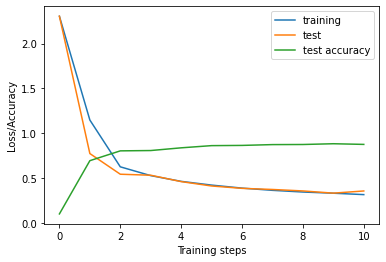

In [51]:
import matplotlib.pyplot as plt
# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()